In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install matplotlib --quiet
!pip install hmmlearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 1.5 MB/s eta 0:00:00


In [3]:
# Import libraries for data manipulation and analysis
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_r_squared = r2_score(test,pred)
  print('R-squared: ', test_r_squared)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_r_squared = r2_score(val, pred_val)
  print('R-squared: ', val_r_squared)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/VMD.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'

df = pd.read_csv(company_csv)
df

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,5980,6240,5980,6240,50,VMD
1,1,2014-01-03,6240,6240,6240,6240,100,VMD
2,2,2014-01-06,6340,6340,6340,6340,860,VMD
3,3,2014-01-07,6340,6340,6340,6340,0,VMD
4,4,2014-01-08,6090,6340,6090,6340,200,VMD
...,...,...,...,...,...,...,...,...
2472,2472,2023-12-04,20300,20300,19700,20300,238300,VMD
2473,2473,2023-12-05,20300,20900,19750,19900,62700,VMD
2474,2474,2023-12-06,20300,20600,20100,20150,51500,VMD
2475,2475,2023-12-07,20150,20300,20000,20150,41100,VMD


In [7]:
# Create a MinMaxScaler object with a specified range
scaler = MinMaxScaler()
data = scaler.fit_transform(np.array(df["close"]).reshape(-1, 1)) #chuan hoa data

# Spilt Dataset (7-2-1)

---



In [8]:
# Split the data
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [ ]:
# ~10p
lowest_mse = 1
best_params = {}

for n_components in [2, 3, 4, 5, 6, 7, 8, 9]:
    for covariance_type in ["diag", "full", "tied"]:
      for i in range(1, 100):
        model = GaussianHMM(n_components=n_components, covariance_type=covariance_type, random_state = i)
        model.fit(train_data)
        y_pred, _ = model.sample(len(test_data))
        mse = mean_squared_error(test_data, y_pred.reshape(-1,1))
        # print("comp="+str(n_components) + ",type=" +str(covariance_type))

        # Update the best parameters if the score improves
        if mse < lowest_mse :
            lowest_mse = mse
            best_params = {
                "n_components": n_components,
                "covariance_type": covariance_type,
                "random_state": i
            }

In [9]:
best_params ={'n_components': 9, 'covariance_type': 'diag', 'random_state': 57}
# {'n_components': 9, 'covariance_type': 'diag', 'random_state': 57}

In [10]:
# Train the HMM model with the best parameters
model = GaussianHMM(**best_params, n_iter=100)
model.fit(train_data)

GaussianHMM(n_components=9, n_iter=100, random_state=57)

In [11]:
all_pred, _ = model.sample(test_size+val_size+30)
all_pred = scaler.inverse_transform(all_pred.reshape(-1,1))
test_pred = all_pred[:test_size]
val_pred = all_pred[test_size:test_size+val_size]
thirty_day_pred = all_pred[test_size+val_size:]

In [12]:
y_test = scaler.inverse_transform(test_data)
y_val = scaler.inverse_transform(val_data)
evaluateModel(y_test,test_pred,y_val,val_pred)

** Testing **
MAE:  8515.060172333846
MAPE:  26.853790368727825
R-squared:  -0.589450099667961
RMSE:  12427.107422628922

** Validate **
MAE:  4852.865547792591
MAPE:  21.39045594642298
R-squared:  -3.6493742612718707
RMSE:  5888.798313461559


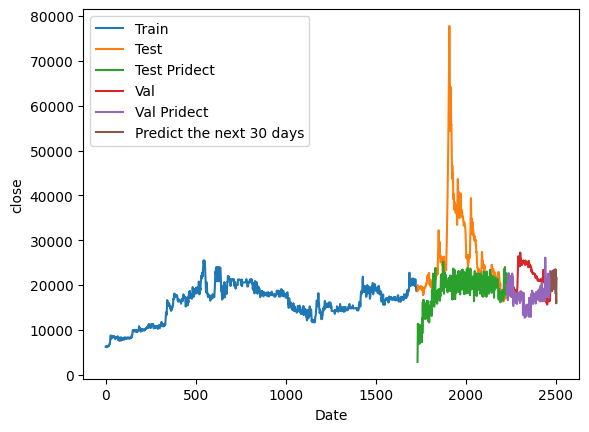

In [13]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.plot(train.index, train.close, label='Train')
plt.plot(test.index, test.close, label='Test')
plt.plot(test.index, test_pred, label='Test Pridect')
plt.plot(validate.index, validate.close, label='Val')
plt.plot(validate.index, val_pred, label='Val Pridect')
plt.plot(df.index[-30:]+30, thirty_day_pred, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('close')
plt.show()